In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output

import seaborn as sns
sns.set_style('white')

In [2]:
from tqdm import tqdm

import os 
from glob import glob
import pandas as pd
import numpy as np
import cv2

In [3]:
import sys

sys.path.append('..')
from src.configs import config
from src.utils import visualisation as vs

%load_ext autoreload
%autoreload 2

In [4]:
import colorsys
from multiprocessing import Pool

import shutil

In [5]:
labels = pd.read_csv(os.path.join(config.PATHS.CSV, 'labels.csv'))
paths = [os.path.join(config.PATHS.IMAGES, fnm) for fnm in labels.filename.unique()]
patients = [(os.path.basename(path), cv2.imread(path, 0)) for path in paths]
patients = sorted(patients, key=lambda x: int(x[0][4:-4]))

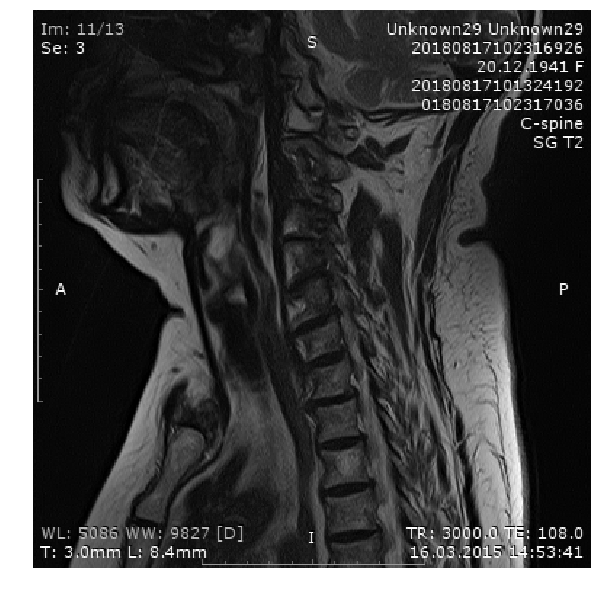

In [6]:
# PATIENT == 13
plt.figure(figsize=(10, 15))
plt.gray()
plt.imshow(cv2.imread('../data/images/img_01050.jpg', 0))
plt.axis('off');

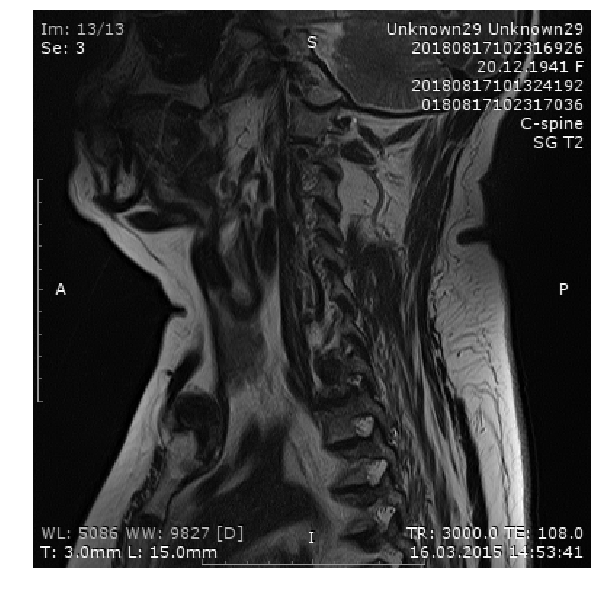

In [8]:
# PATIENT == 13
plt.figure(figsize=(10, 15))
plt.gray()
plt.imshow(cv2.imread('../data/images/img_01052.jpg', 0))
plt.axis('off');

### Weight connections

In [ ]:
connections = list()
for i, (_, refer) in enumerate(tqdm(patients)):
    flows = list()
    for j, (name, image) in enumerate(patients):
        if i == j:
            continue
        flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        flows.append((j, name, mag.mean()))
    connections.append(flows)

 95%|█████████▍| 335/354 [1:10:10<03:58, 12.57s/it]

### Clique search

In [28]:
def find_links(connections, init, links=[]):
    def check_branch(child):
        children = sorted(connections[child[0]], key=lambda x: x[2])[:2]
        idxs = [c[0] for c in children]
        if any(i in links for i in idxs):
            children = [i for i in idxs if i not in links]
            if len(children):
                find_links(connections, child[0], links)
            else:
                links.append(child[0])

    links.append(init)
    children = sorted(connections[init], key=lambda x: x[2])
    children = [c for c in children if c[0] not in links][:2]
    for c in children:
        check_branch(c)
    return set(links)


In [57]:
links = list()
idxs = list(range(len(patients)))
while idxs:
    i = idxs.pop()
    link = find_links(connections.copy(), i, [])
    for idx in link:
        if idx in idxs:
            idxs.remove(idx)
    links.append(link)

In [58]:
merged = list()
while links:
    refer = links.pop()
    for i, link in enumerate(links):
        if refer.intersection(link):
            refer = refer.union(link)
            links.pop(i)
            break
    merged.append(refer)

### Visualisation:

In [98]:
def make_image_row(image, subax):
    subax[0].imshow(image[0][1])
    subax[0].set_title(image[0][0])
    subax[0].axis('off')
    subax[1].imshow(image[1][1])
    subax[1].set_title(image[1][0])
    subax[1].axis('off')
    subax[2].imshow(image[2][1])
    subax[2].set_title(image[2][0])
    subax[2].axis('off')
    subax[3].imshow(image[3][1])
    subax[3].set_title(image[3][0])
    subax[3].axis('off')
    return subax

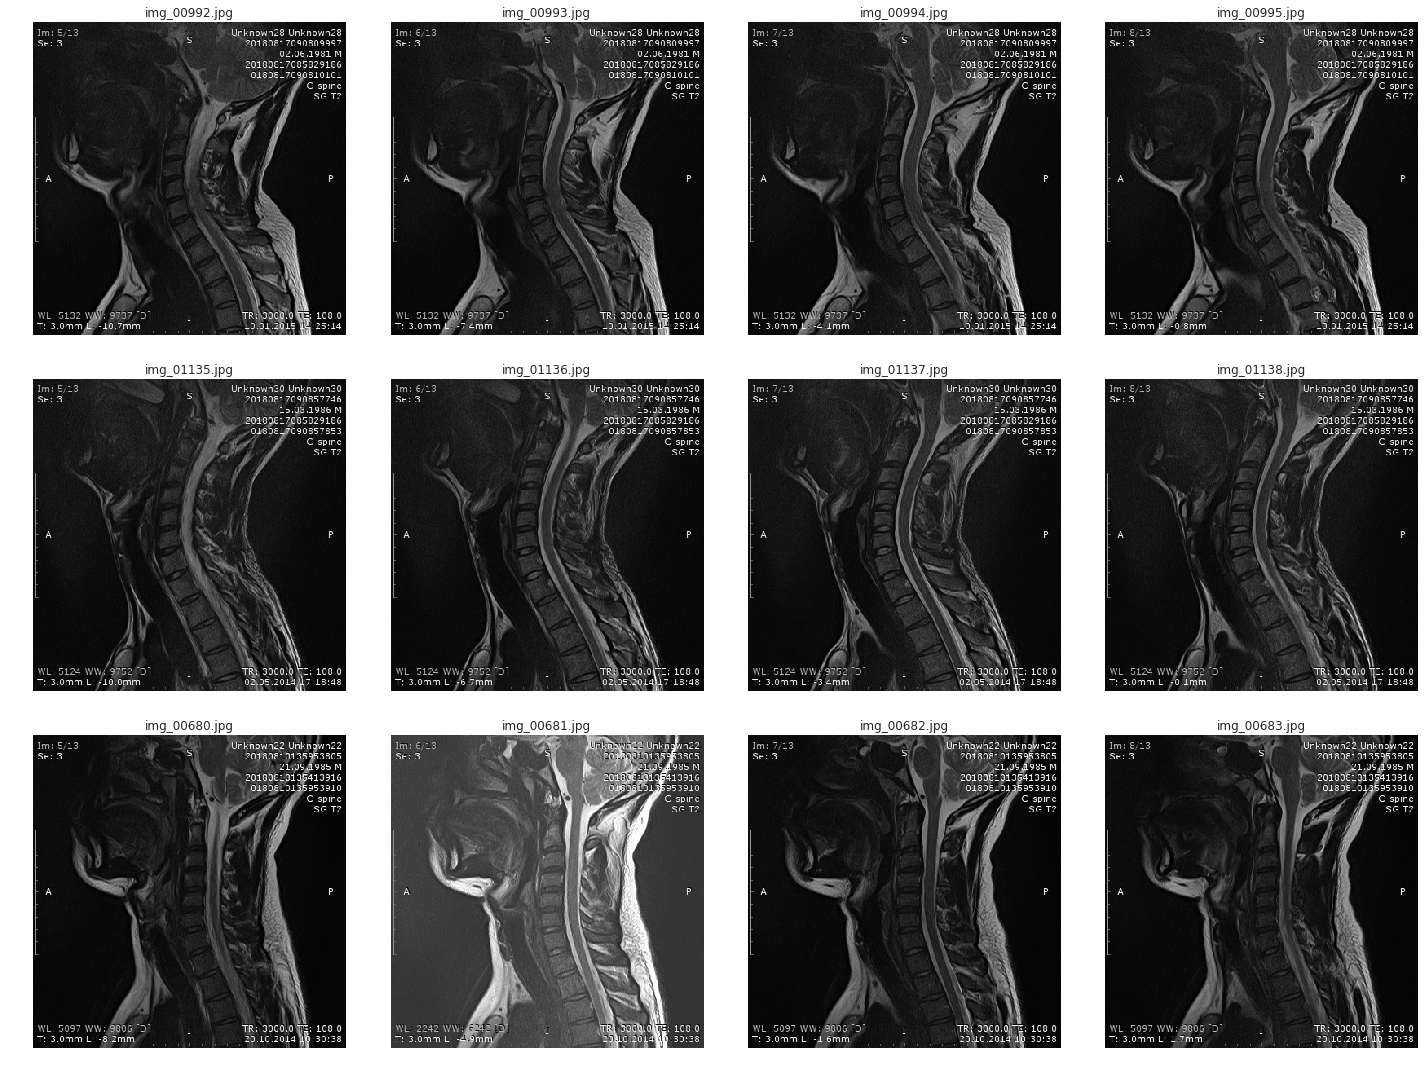

In [104]:
links_vis = [l for l in merged if len(l) >= 4]
infer_ids = np.random.randint(len(links_vis), size=3)

fig, ax = plt.subplots(len(infer_ids), 4, figsize=(20, len(infer_ids) * 5))

for i, idx in enumerate(infer_ids):
    link = list(links_vis[idx])[:4]
    pats = [patients[l] for l in link]
    make_image_row(pats, ax[i])    
fig.tight_layout()
fig.save(os.path.join(config.PATHS.SUB, 'patients_clustering.png'))
plt.show()

In [70]:
labels['instance_id'] = 0

for i, link in enumerate(merged):
    for idx in link:
        key = patients[idx][0]
        idxs = labels.query('filename==@key').index
        labels.loc[idxs, 'instance_id'] = i

In [107]:
path = os.path.join(config.PATHS.CSV, 'labels.csv')
labels.to_csv(path, index=False)
labels.head()

,coords,name,id,filename,is_normal,type,instance_id
0,161 103 202 103 202 126 161 126,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck,60
1,161 132 204 132 204 154 161 154,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck,60
2,161 163 210 163 210 181 161 181,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck,60
3,161 185 214 185 214 201 161 201,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck,60
4,165 209 219 209 219 227 165 227,shejnyj-mezhpozvonochnyj-disk-zdorovyj,3111,img_01047.jpg,True,neck,60


### Check consistency on skipped data:

In [24]:
connections_fast = list()
for i, (_, refer) in enumerate(tqdm(patients[1:-1])):
    flows = list()
    for name, image in [patients[i], patients[i + 2]]:
        flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        flows.append((name, mag.mean()))
    connections_fast.append(flows)

100%|██████████| 352/352 [00:25<00:00, 13.62it/s]


In [75]:
connections_fast[: 10]

[[('img_00005.jpg', 1.8694301), ('img_00019.jpg', 10.007001)],
 [('img_00007.jpg', 10.412676), ('img_00020.jpg', 1.2040753)],
 [('img_00019.jpg', 1.1997758), ('img_00030.jpg', 10.366682)],
 [('img_00020.jpg', 10.755322), ('img_00031.jpg', 1.4603006)],
 [('img_00030.jpg', 1.4178168), ('img_00032.jpg', 1.3536897)],
 [('img_00031.jpg', 1.3267897), ('img_00043.jpg', 15.615845)],
 [('img_00032.jpg', 11.294395), ('img_00044.jpg', 1.1244483)],
 [('img_00043.jpg', 1.1573616), ('img_00045.jpg', 1.3341178)],
 [('img_00044.jpg', 1.3752847), ('img_00046.jpg', 1.4053056)],
 [('img_00045.jpg', 1.4362848), ('img_00056.jpg', 15.785329)]]

In [20]:
paths = glob('../data/images/*.jpg')
paths = sorted(paths, key=lambda x: int(os.path.basename(x)[4:-4]))

connections_full = list()
for i, refer in enumerate(tqdm(paths[1:-1])):
    flows = list()
    refer = cv2.imread(refer, 0)
    for path in [paths[i], paths[i + 2]]:
        image = cv2.imread(path, 0)
        flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
        mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
        flows.append((os.path.basename(path), mag.mean()))
    connections_full.append(flows)

100%|██████████| 889/889 [01:09<00:00, 12.77it/s]


In [76]:
connections_full[:10]

[[('img_00000.jpg', 1.9980261), ('img_00002.jpg', 1.8928427)],
 [('img_00001.jpg', 1.870687), ('img_00003.jpg', 1.7042012)],
 [('img_00002.jpg', 1.6761752), ('img_00004.jpg', 1.4950955)],
 [('img_00003.jpg', 1.4598922), ('img_00005.jpg', 1.2402688)],
 [('img_00004.jpg', 1.2612133), ('img_00007.jpg', 1.7555095)],
 [('img_00005.jpg', 1.8694301), ('img_00008.jpg', 1.3217585)],
 [('img_00007.jpg', 1.2992324), ('img_00009.jpg', 1.4601136)],
 [('img_00008.jpg', 1.4477477), ('img_00010.jpg', 1.6700991)],
 [('img_00009.jpg', 1.6579496), ('img_00011.jpg', 1.7616595)],
 [('img_00010.jpg', 1.7181001), ('img_00012.jpg', 1.6864022)]]

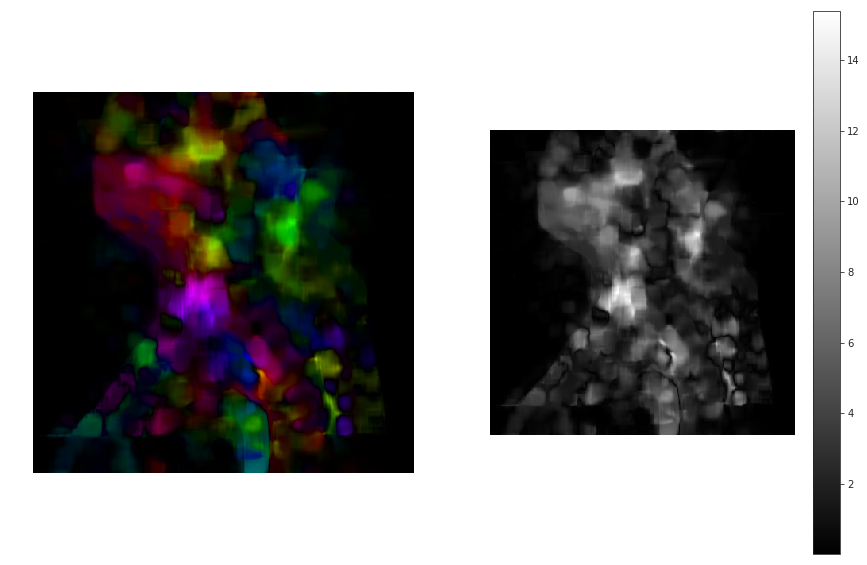

In [10]:
hsv = np.zeros(refer.shape + (3, ))
hsv[...,1] = 255

flow = cv2.calcOpticalFlowFarneback(refer, image, None, 0.5, 5, 15, 3, 5, 1.2, 0)
mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
hsv[...,0] = ang * 180 / np.pi / 2
hsv[...,2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)

plt.figure(figsize=(15, 10))
plt.subplot(121)
plt.imshow(bgr)
plt.axis('off');
plt.subplot(122)
plt.imshow(mag)
plt.colorbar()
plt.axis('off');